# Validate Model

This notebook aims to evaluate the performance of trained models by simulating an environment run and analyzing the results

First, all models that were trained using random search are evaluated and the best hyperparameters are chosen for further training. The hyperparamters are contained in the folder of each model. Therefore, they need to be extracted first.

In [2]:
%load_ext autoreload
%autoreload 2
from dataset.containers import DataSet
import logging
import gymnasium as gym
from typing import List
from environment import MarketEnv
import constants
import pprint
import json, glob, os, pickle, datetime
from visualizer import Visualizer
from util import get_datasets, get_train_validate_test_datasets
import os 
from pytorch_lightning import loggers
import ppo
from constants import *
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from environment import Config
from pathlib import Path
import re
from tqdm.notebook import tqdm

logging.basicConfig(level=logging.INFO)

In [2]:
model_paths = []

for f in glob.glob(os.path.join(MODEL_PATH, "generated", "lightning_logs", "version_*")):
    model_paths.append(glob.glob(os.path.join(f, "*.ckpt"))[-1])

In [6]:
# Load the datasets
datasets = get_datasets()
train_sets, validation_sets, test_sets = get_train_validate_test_datasets(datasets)

In [3]:
def validate_model(model: ppo.PPO, env: gym.Env):
    state = env.reset(seed=44)
    done = False
    states = []
    actions = []
    rewards = []
    model.eval()
    hn = model.actor.actor_net.init_hidden(1)
    while not done:
        states.append(state)
        action, hn = model.make_move(state, hn, "cpu")
        actions.append(action)
        state, reward, done, info = env.step(action)
        rewards.append(reward)
        state = (state,info)
    return (states, actions, rewards)

In [4]:
def get_traces_for_dataset(datasets: List[DataSet], model_paths: List[str]):
    traces = []
    gym.register("MarketEnv-v0", entry_point=MarketEnv)
    for model_path in tqdm(model_paths, desc="Running validation"):
        model = ppo.PPO.load_from_checkpoint(model_path, env=gym.make("MarketEnv-v0", datasets=datasets, config = Config()))
        model.config.STD_RUN_DURATION = 100
        model.config.STD_RUN_DURATION = 0.01
        model.config.STOCK_HOLDING_REWARD = 0
        model.config.TRUNCATION_PENALTY = 0
        model.config.CONTINUOUS_MODEL = model.actor.actor_net.output_size == 1
        model.config.MAX_BUY_LIMIT = 10
        env = gym.make("MarketEnv-v0", datasets=datasets, config=model.config)
        model.env = env

        match = re.search(r'version_(\d+)', model_path)
        if match:
            model_version = match.group(1)  # Extract the version number
        else:
            raise ValueError(f"Could not extract version number from model path: {model_path}")

        traces.append((model_version, *validate_model(model, env)))
    return traces

## Analysis of random search models

The statistics of the models generated by random search are evaluated and the hyperparameters of the best performing models are used for further training. 

Important criterias are a high portfolio value as well as the balance of the number of sell and buy actions.

For variety, the first dataset used for validation shows an increasing trend, the second one shows a decreasing trend.

### Conclusion

Models 10, 17, 40 and 41 are chosen as the best ones, either because of their portfolio value. Most models choose to buy more than they can. So the primary objective of the next training is ensuring that the actions dont have to be truncated.

In [ ]:
# Random dataset
traces = get_traces_for_dataset(validation_sets, model_paths)

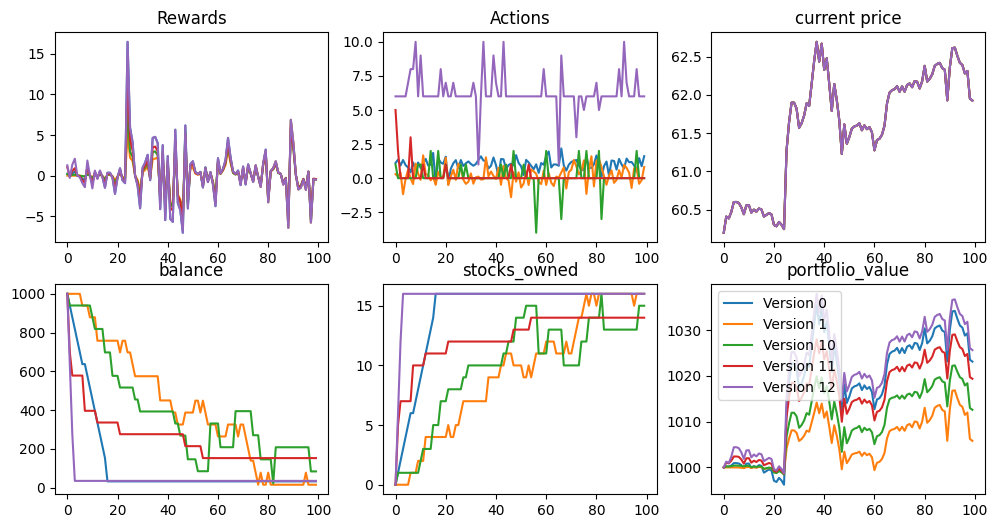

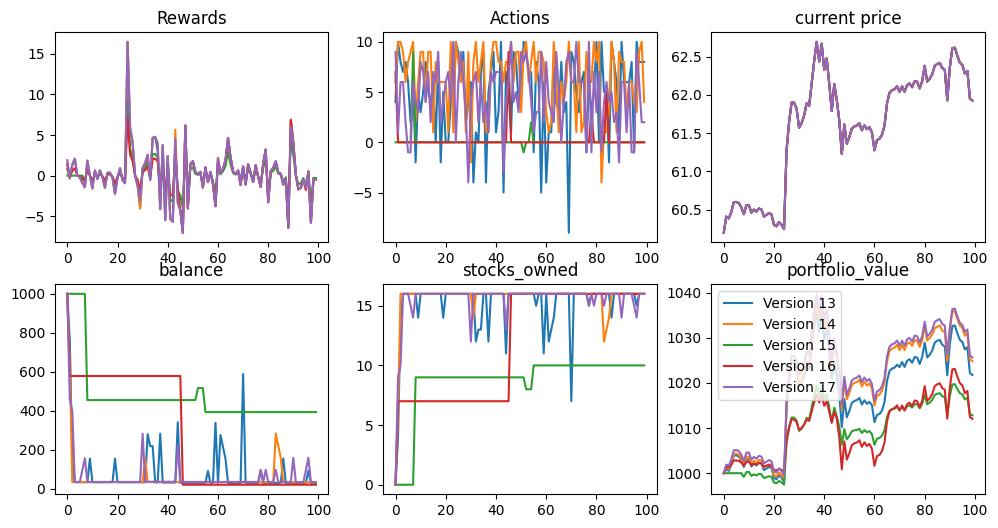

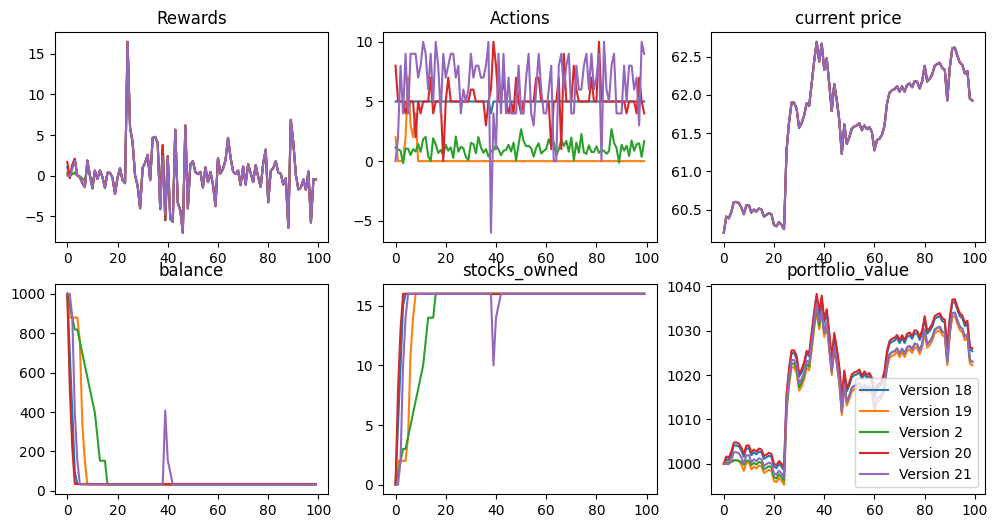

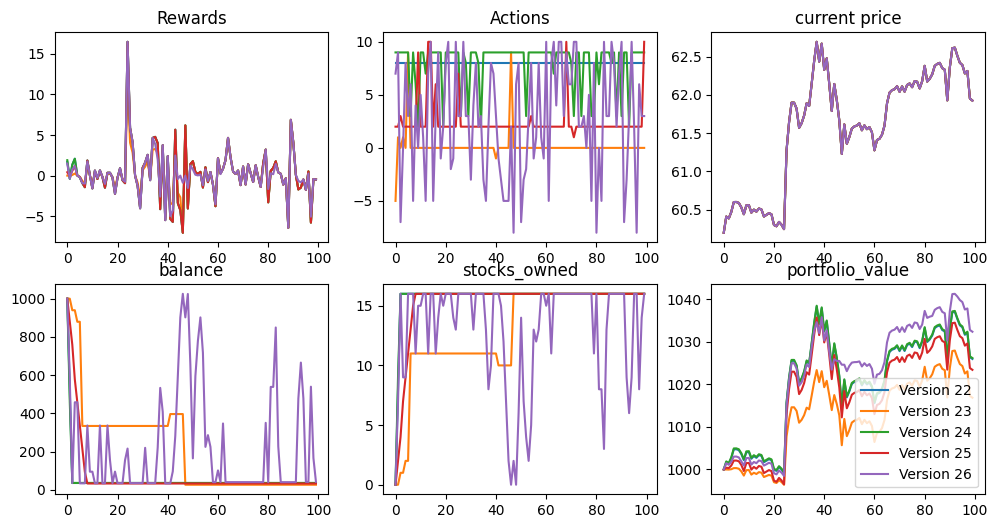

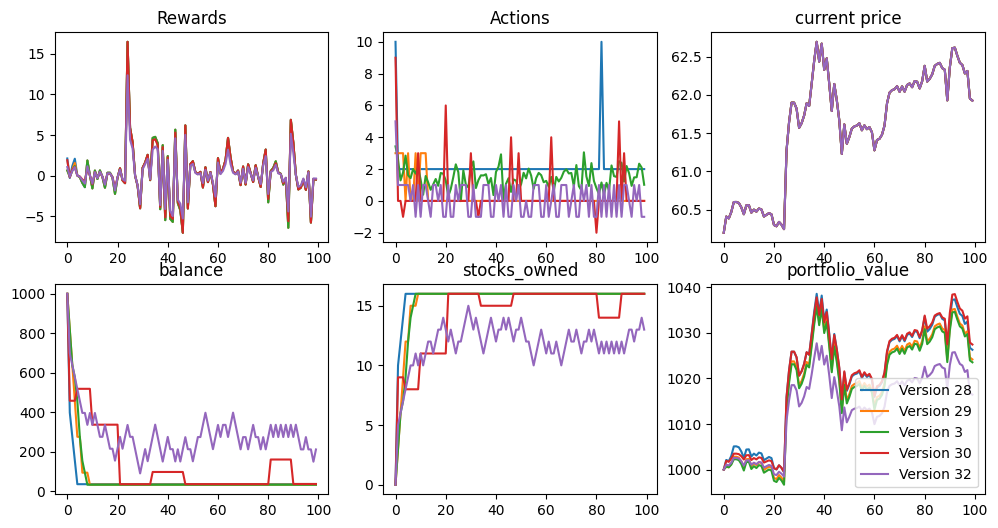

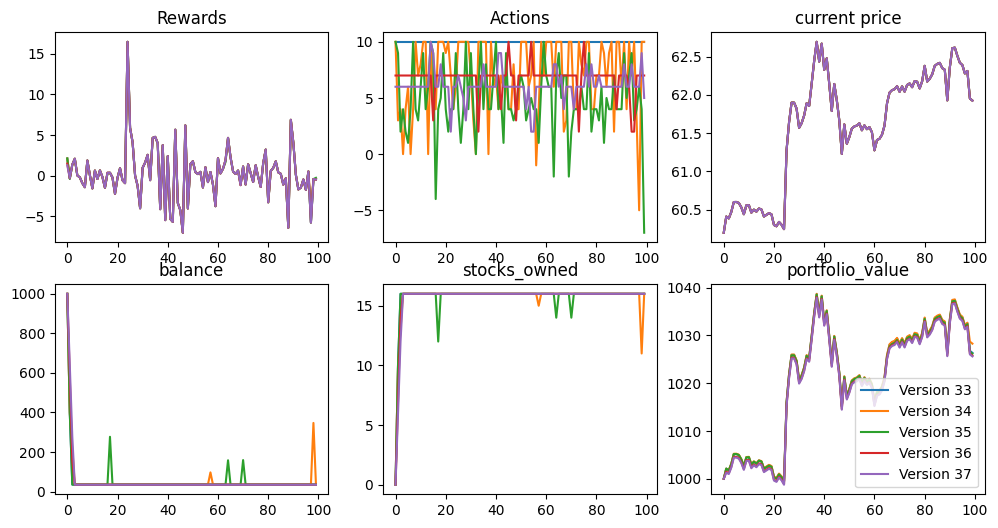

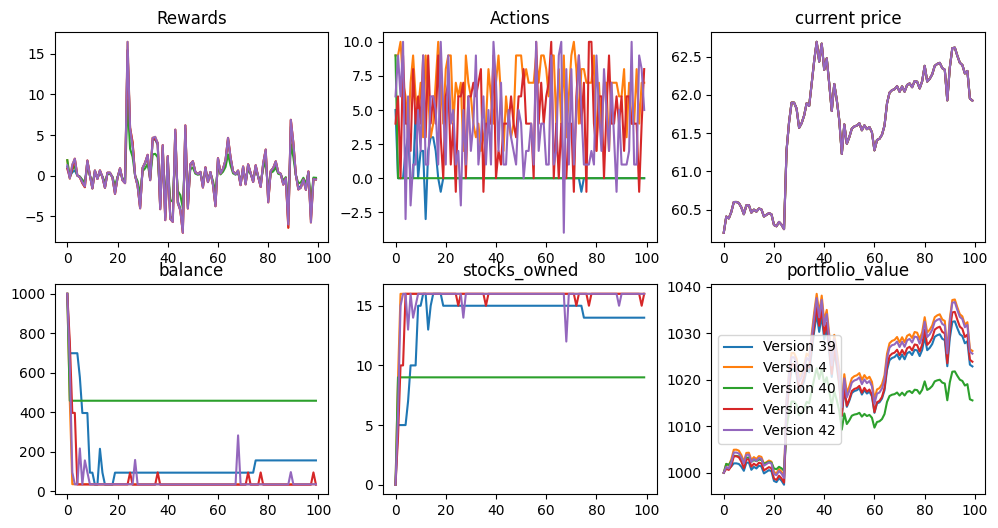

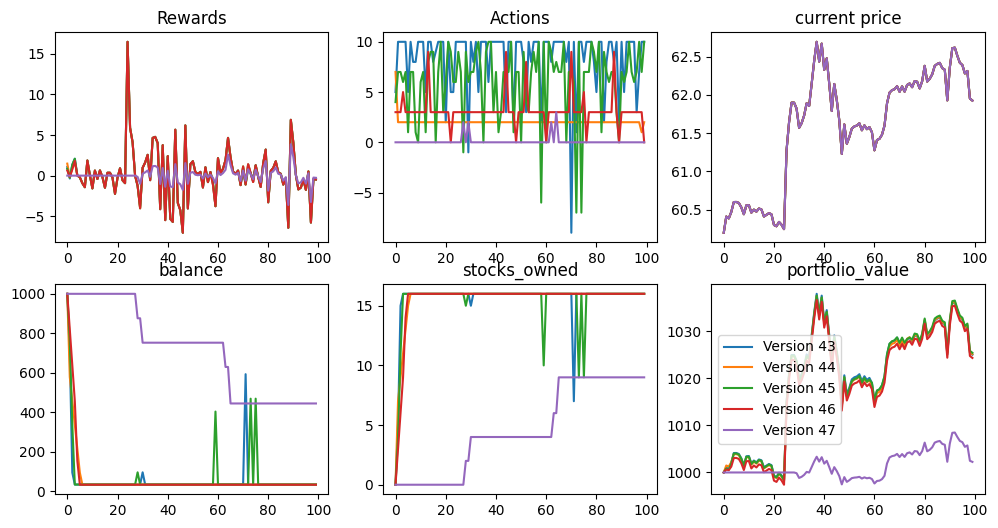

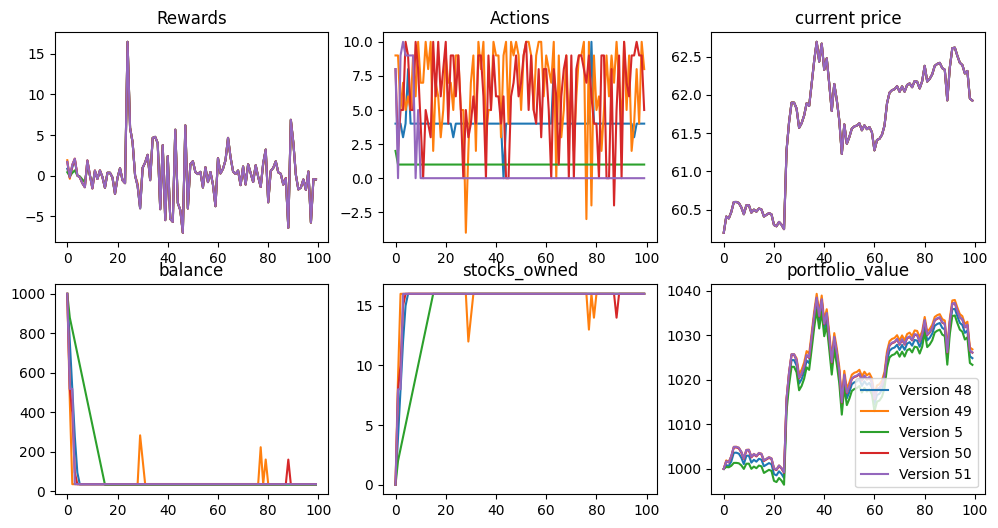

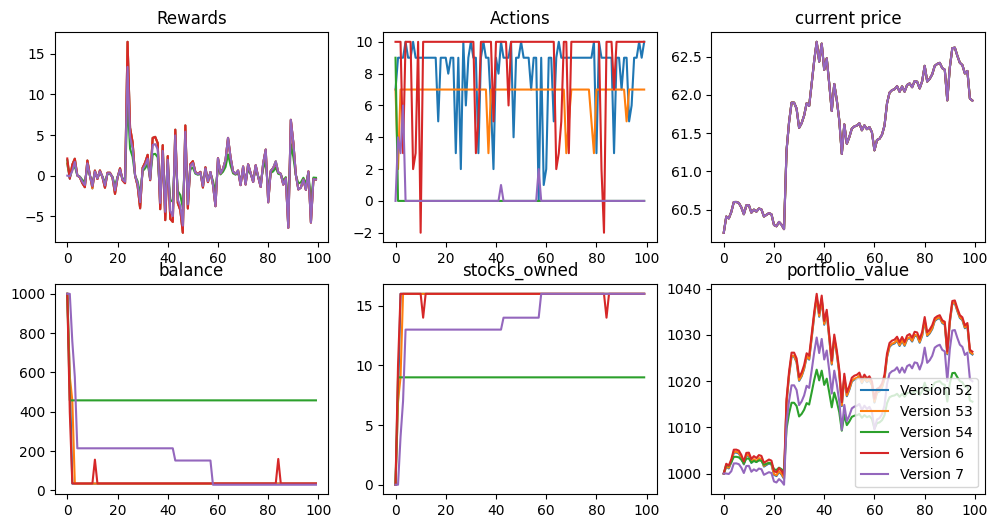

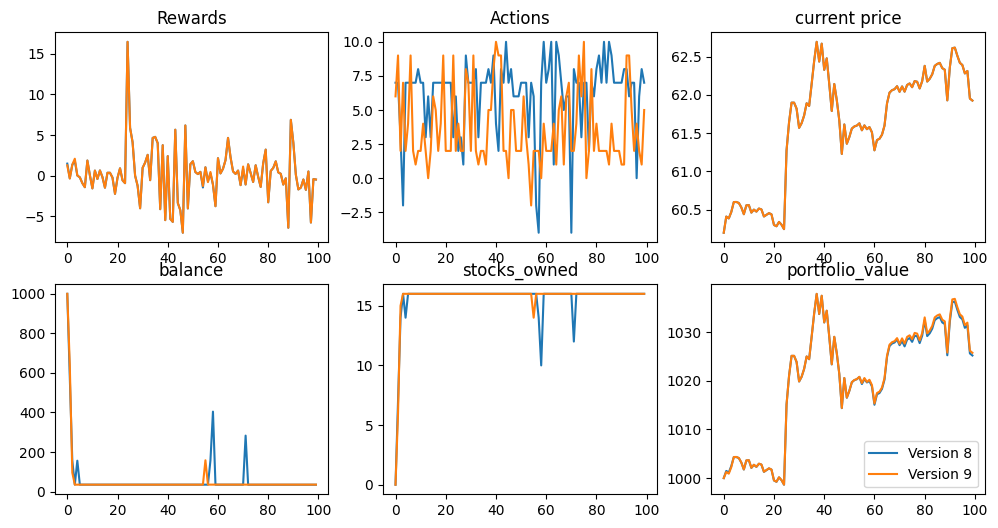

In [7]:
distance = 5
for x in range(0, len(traces), distance):
    Visualizer.plot_traces(traces[x:min(len(traces), x+distance)])

In [ ]:
# ZM dataset
traces = get_traces_for_dataset([validation_sets[-1]], model_paths)

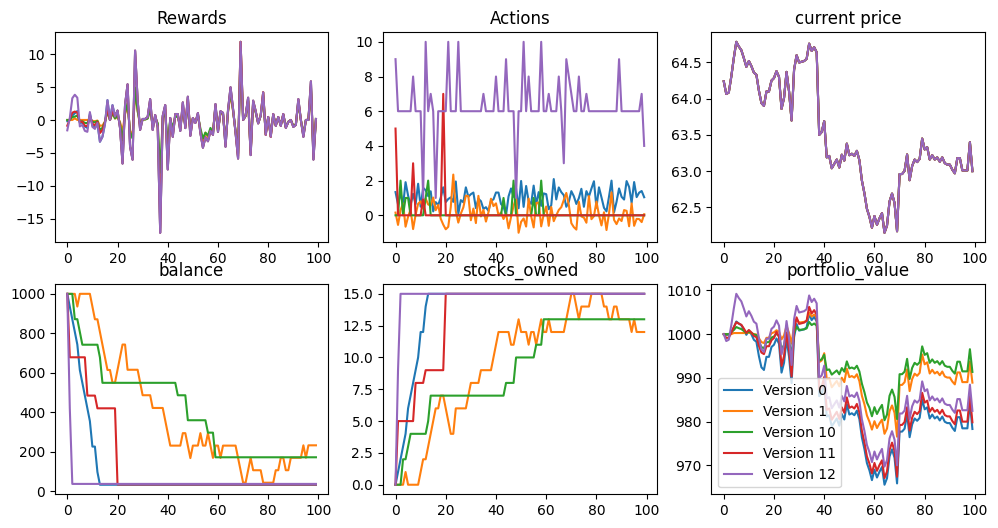

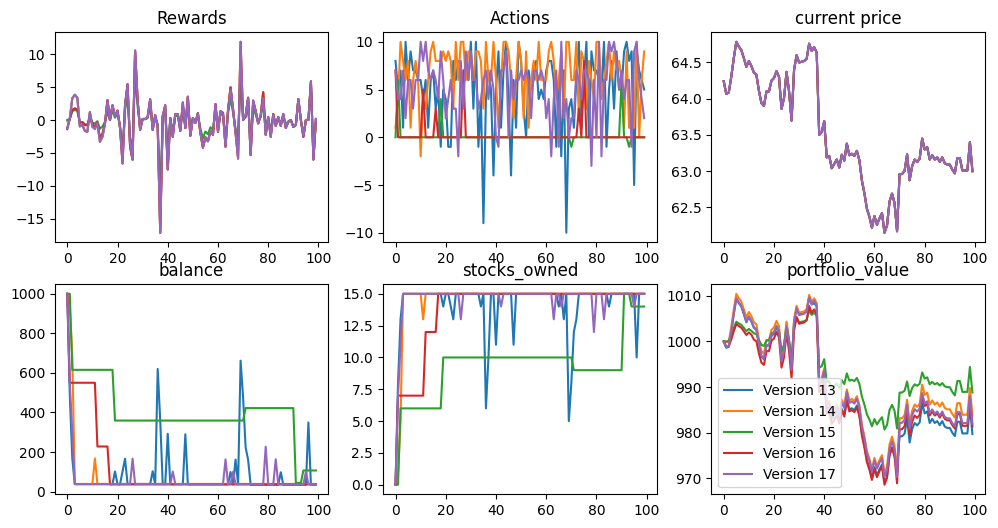

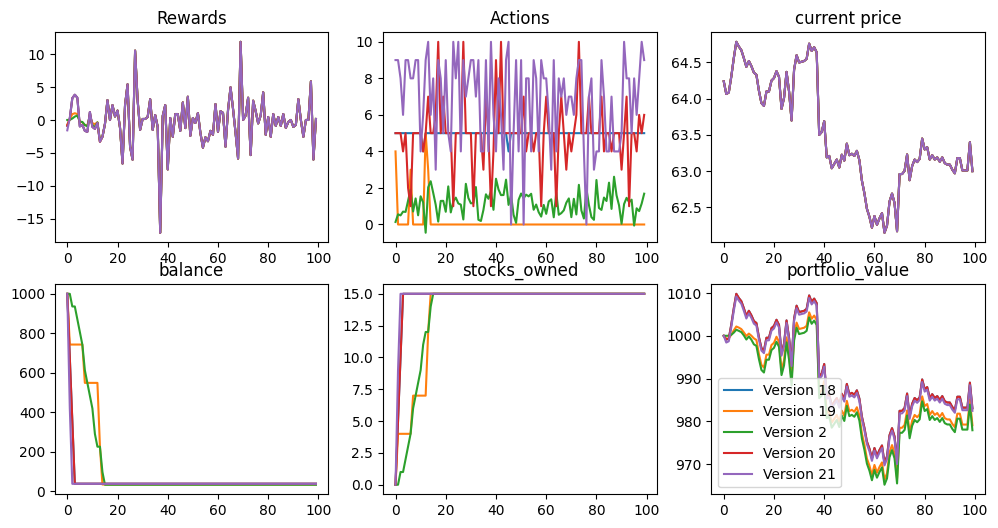

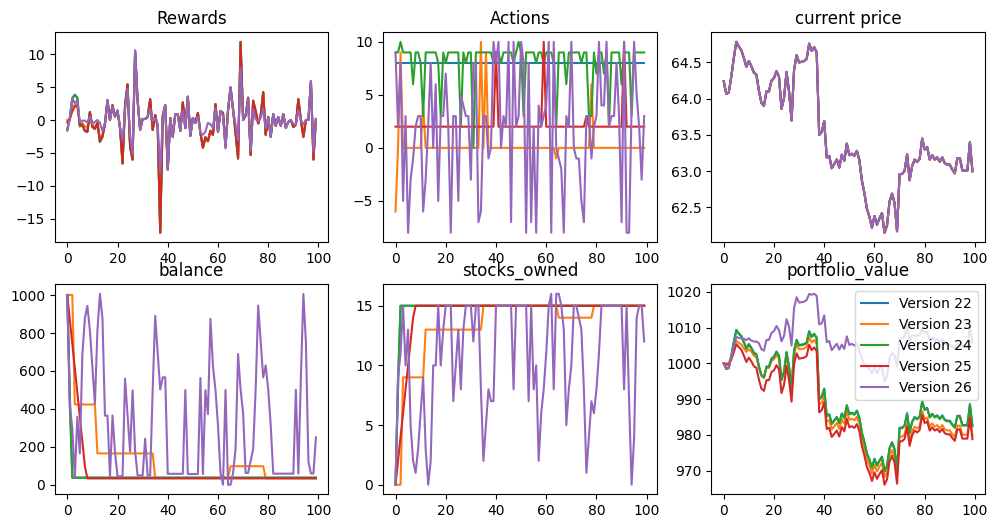

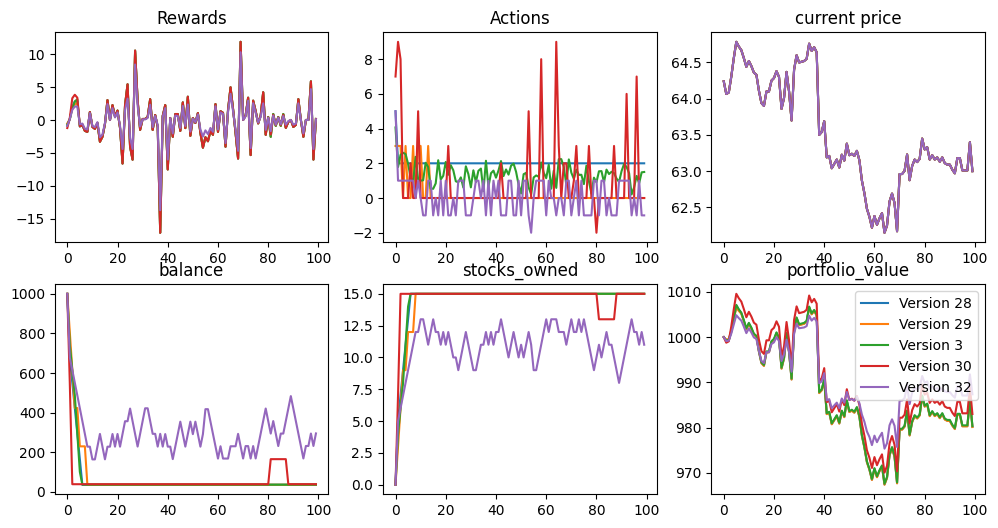

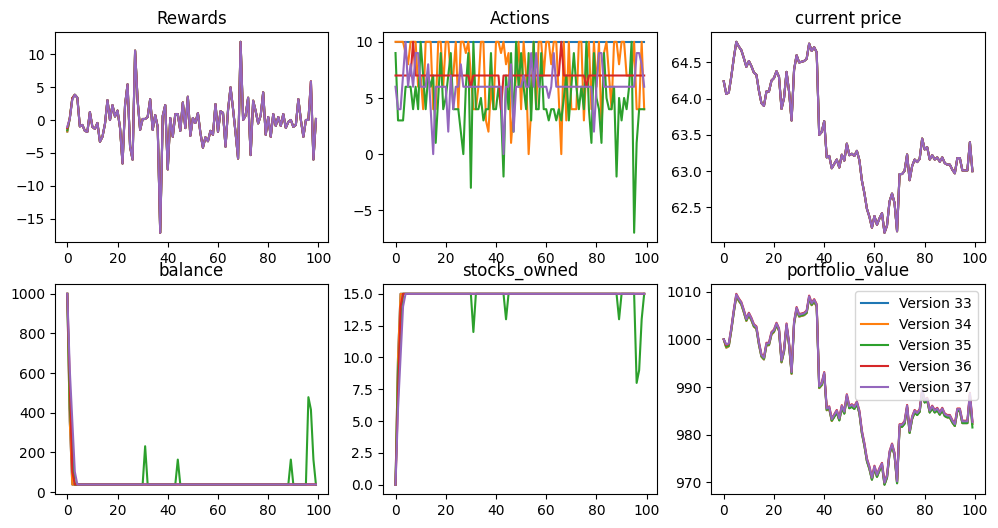

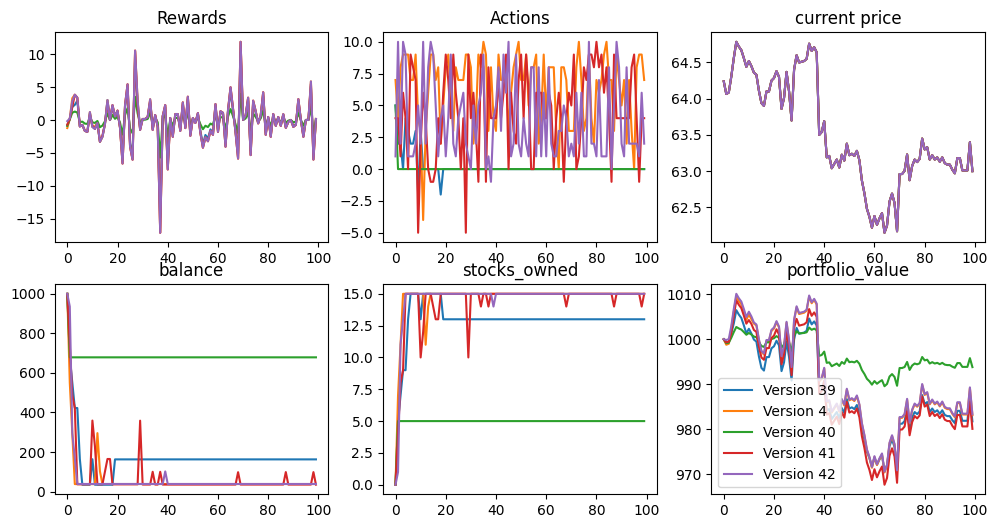

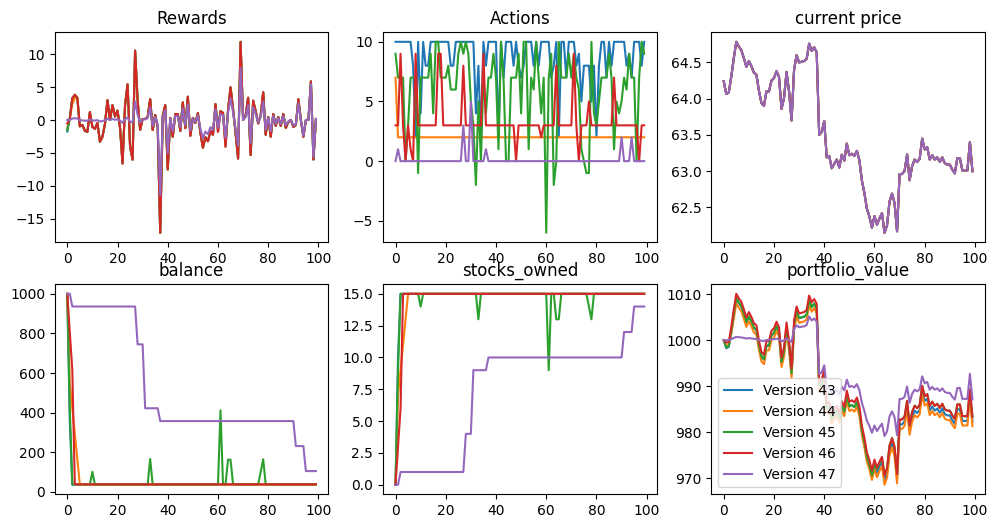

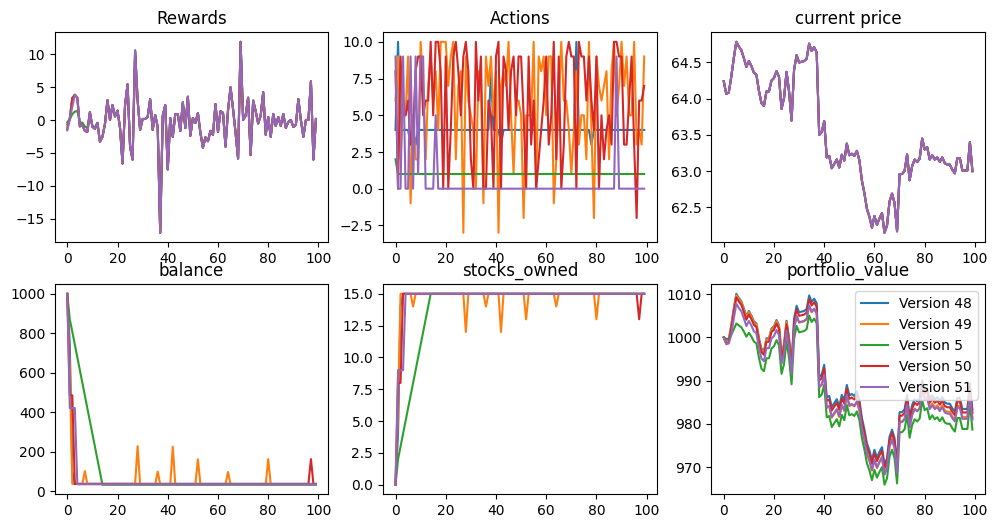

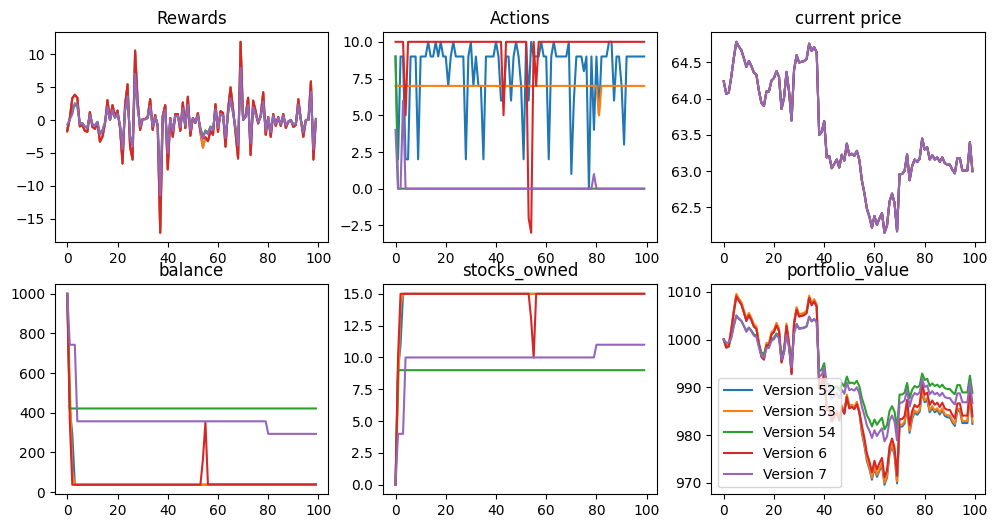

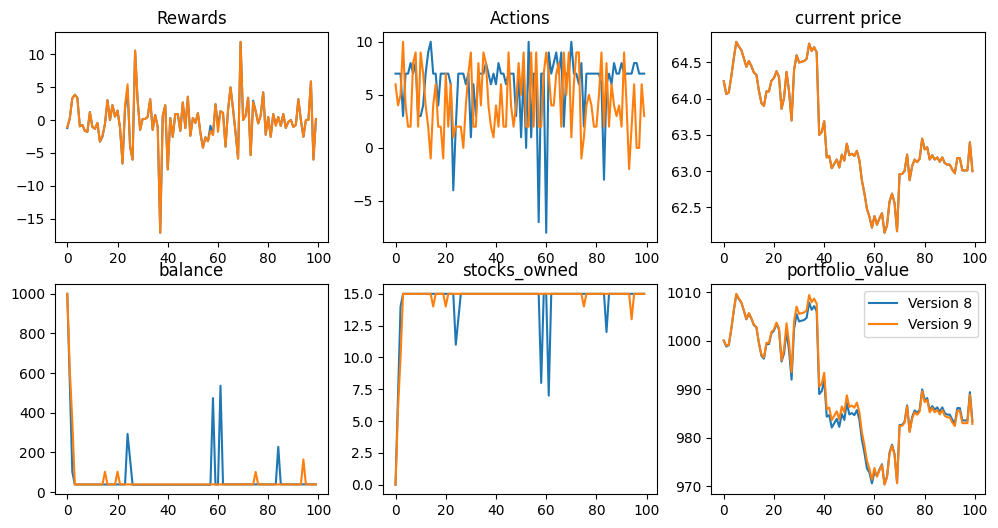

In [9]:
distance = 5
for x in range(0, len(traces), distance):
    Visualizer.plot_traces(traces[x:min(len(traces), x+distance)])

# Analysis of more trained chosen models

The chosen models that have been trained with more epochs, are now evaluated.

## Conclusion

The trained models do not need to be truncated as often as before. However, the performance of the models does not seem to have increased as much as I was hoping. I believe that further training with even more epochs (which is my next step) will improve the results.

In [ ]:
model_paths = [
    r"C:\Users\Daniel\OneDrive - TU Wien\Uni\7. Semester\ADL\repo\adl\models\saved_models\version_55\saved.ckpt",
    r"C:\Users\Daniel\OneDrive - TU Wien\Uni\7. Semester\ADL\repo\adl\models\saved_models\version_57\saved.ckpt",
    r"C:\Users\Daniel\OneDrive - TU Wien\Uni\7. Semester\ADL\repo\adl\models\saved_models\version_58\saved.ckpt",
    r"C:\Users\Daniel\OneDrive - TU Wien\Uni\7. Semester\ADL\repo\adl\models\saved_models\version_59\saved.ckpt"
]
traces = get_traces_for_dataset(validation_sets, model_paths)
traces2 = get_traces_for_dataset([validation_sets[-1]], model_paths)

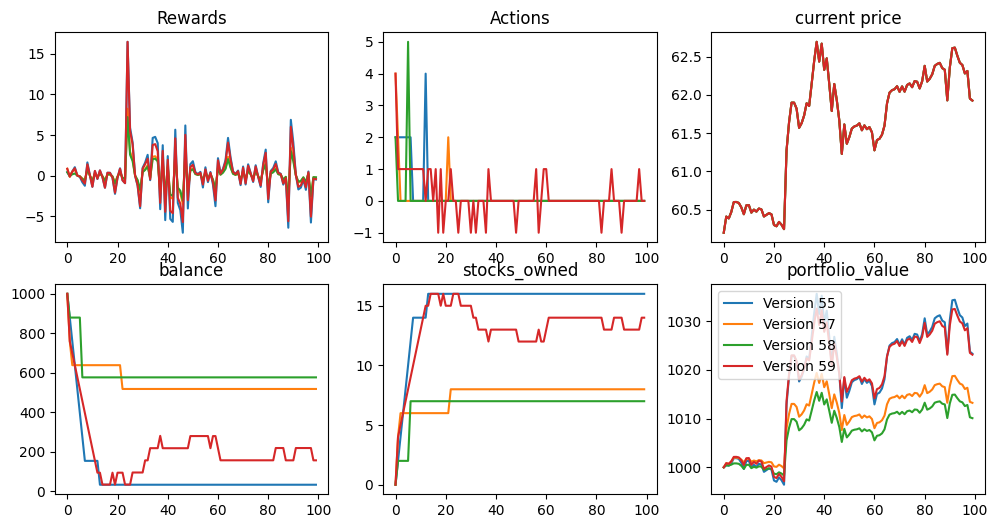

In [14]:
Visualizer.plot_traces(traces)

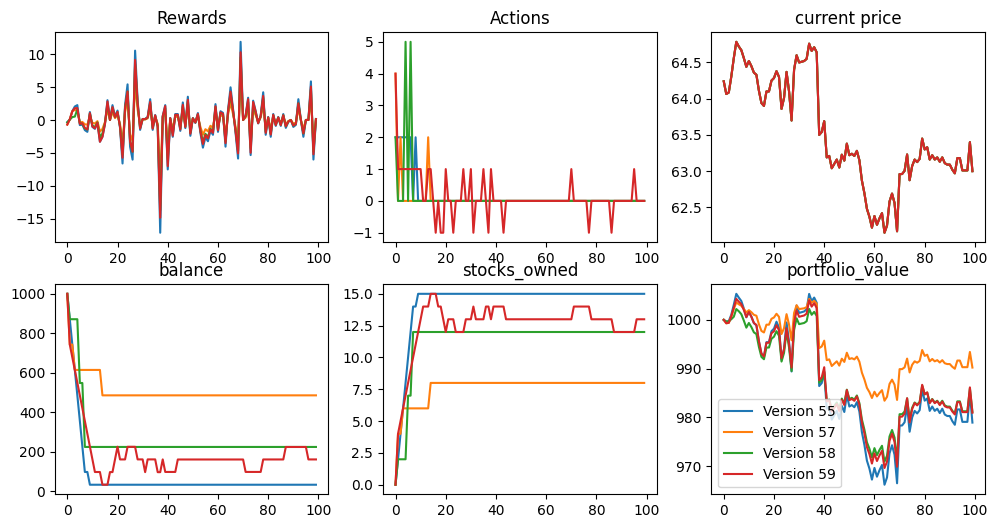

In [15]:
Visualizer.plot_traces(traces2)

In [7]:
model_paths = [
    r"C:\Users\Daniel\OneDrive - TU Wien\Uni\7. Semester\ADL\repo\adl\models\generated\lightning_logs\version_69\model-epoch=958-avg_reward=0.04050.ckpt",
]
traces = get_traces_for_dataset(validation_sets, model_paths)
traces2 = get_traces_for_dataset([validation_sets[-1]], model_paths)

Running validation:   0%|          | 0/1 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Daniel/OneDrive - TU Wien/Uni/7. Semester/ADL/repo/adl/models/generated/lightning_logs/version_69/checkpoints/model-epoch=958-avg_reward=0.04050.ckpt'